## Modelo de la red

In [ ]:
#Acontinuacion se implementa una red neuronal 
# con minibach tiene particularidad  maneja hiperparametros como LR, nolinearidad, w, SGD
#JESUS DAVID HURTADO 
#Mini-Batch Gradient Descent para entrenar un modelo cuadrático
#Clase 2 .2 Crear un dataset sintético con 10,000 muestras a partir de la siguiente expresión (donde “x” es la feature que toma valores entre 0 y 4, e “y” es la salida):

In [711]:
import numpy as np
from numpy.core import machar
import matplotlib.pyplot as plt
import math
#Carga de datos
import numpy as np
from itertools import combinations
X_train = np.zeros((10000,13))     

X_train = np.random.randint(0, 4, size=(10000, 13))
X_train

array([[1, 0, 3, ..., 0, 0, 3],
       [2, 1, 3, ..., 2, 3, 1],
       [0, 0, 2, ..., 0, 2, 3],
       ...,
       [2, 1, 2, ..., 3, 1, 2],
       [3, 2, 2, ..., 1, 1, 0],
       [2, 1, 1, ..., 2, 1, 0]])

In [712]:
#y de salida

y_train = np.zeros((10000,1))            
for i, val in enumerate(X_train):
    for m, x in enumerate(val):
     #print (x, ",",val2)
      s = 16 * x      
      s = math.sin(s)
      y_train[i] = - ( ( x - 2 ) **2  + 3 + 0.2 ) * s 

            

In [713]:
y_train.shape

(10000, 1)

In [714]:
def create_mini_batches(X, y, batch_size):
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
  
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, : 1]
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:,:  1]
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

In [715]:
class MLP(object):
  def __init__(self, dims, optimizer_factory, non_linearities, input_dim, rng_seed = None):
    """
    Multilayer Perceptron class. 

    Params:
    ===============
    dims (list of int): list of number of neurons for each layer, including the output one.
    optimizer_factory (callable): function which returns an Optimizer object upon call.
    non_linearities (list of class): list of nonlinearities to be used after each layer, including the output one.
    input_dim (int): dimension of an individual input.
    rng_seed (int, optional): seed for initialization.

    Note: non_linearities and dims must be of same length.
    """
    # check lengths
    if len(dims) != len(non_linearities):
      raise ValueError("dims' and Non_linearities' lengths do not match")
    
    # initialize RNG
    rng = np.random.default_rng(rng_seed)

    # construct a list of Layers with matching dimension and non-linear activation function
    in_dims = [input_dim] + dims[:-1]
    self.layers = [Layer(n_in, n_out, non_linearity, optimizer_factory, rng) 
                    for n_in,n_out,non_linearity in zip(in_dims,dims, non_linearities)]


  def predict(self, X):
    """
    Produce a prediction for the n samples given in the form of a (input_dim, n) matrix.
    Params:
    ===============
    X (float, shape: input_dim x n): matrix of n samples, each of input_dim dimension.
    """
    # X can be interpreted as the output of a previous layer
    prediction = X

    # sequentially apply forward pass
    for layer in self.layers:
      prediction = layer.forward(prediction)

    return prediction
    
  def update(self, cost_gradient):
    """
    Propagate the errors through the layers.
    Params:
    ===============
    cost_gradient (float, shape: dims[-1] x 1)
    """
    
    # cost gradient is the cost derivative wrt last layer
    dY = cost_gradient

    # sequentially apply backwards update, in reversed order
    for layer in reversed(self.layers):
      dY = layer.backwards(dY)

In [716]:
class Layer(object):
  def __init__(self, n_in, n_out, non_linearity_class, optimizer_factory, rng):
    self.activation = non_linearity_class()
    self.optim = optimizer_factory()
    self.w = rng.standard_normal(size=(n_out, n_in))  * 0.1 # W shape is (n_out,n_in)
    self.b = rng.uniform(size=(n_out, 1))                   # b shape is (n_out, 1)

    #print(f"W= {self.w.shape}")
    #print(f"b= {self.b.shape}")
    # this may help later :)
    self.last_output = None
    self.last_input = None

  def forward(self, X):
    self.last_input = X
    
    z = self.w @ X + self.b

    self.last_output = self.activation.f(z)

    return self.last_output

  def backwards(self, dY):
    
    dz = dY * self.activation.df()

    dW = dz @ self.last_input.T

    db = np.sum(dz, axis=1, keepdims=True)

    dX = self.w.T @ dz

    self.w, self.b = self.optim.update(self.w, self.b, dW, db)

    return dX

In [717]:
class NonLinearity(object):

  def __init__(self):
    self.last_z = None
  
  def f(self, z):
    raise NotImplementedError("function evaluation not implemented")

  def df(self):
    raise NotImplementedError("function derivative not implemented")

In [718]:
class Relu(NonLinearity):

  def __init__(self):
    super().__init__()

  def f(self,z):
    self.last_z = z
    return np.maximum(z,0)

  def df(self):
    return (self.last_z >= 0).astype(float)

In [719]:
class Identity(NonLinearity):

  def __init__(self):
    super().__init__()

  def f(self,z):
    self.last_z = z
    return z

  def df(self):
    return np.ones_like(self.last_z)  

In [720]:
class Optimizer(object):

  def update(self, W, b, dW, db):
    raise NotImplementedError("optimizer update rule not implemented")

In [721]:
class VGD(Optimizer):

  def __init__(self, learning_rate):
    self.lr = learning_rate

  def update(self, W_old, b_old, dW, db):
    # vanilla GD: theta_t+1 = theta_t - alpha * gradient
    W_new = W_old - self.lr * dW
    b_new = b_old - self.lr * db

    return W_new, b_new

def factory_VGD(lr):
  return lambda : VGD(lr)

In [722]:
class Cost(object):

  def score(self, Y_true, Y_hat):
    raise NotImplementedError("cost scoring function not implemented")

  def derivative(self, Y_true, Y_hat):
    raise NotImplementedError("cost derivative function not implemented")

In [723]:
class MSE(Cost):

  def score(self, Y_true, Y_hat):
    return 0.5 * np.average(np.square(Y_true - Y_hat))

  def derivative(self, Y_true, Y_hat):
    return (Y_hat - Y_true) / Y_hat.size

## Código para pruebas

In [724]:
# hiperparámetros

lr = 0.001
rng_seed = 654
epochs = 5

In [725]:
# preparing data, train - test validation
# 70-30 split


In [726]:
# initialization

loss = MSE()

nn = MLP(
    dims = [8,y_train.shape[1]], 
    optimizer_factory = factory_VGD(lr), 
    non_linearities = [Relu, Identity], 
    input_dim = X_train.shape[1], 
    rng_seed = rng_seed
)

nn

In [728]:
# Se implementa el bach back propagation
# y se actualiza el gradiente para evaluar la funcion de perdida



In [729]:
import matplotlib.pyplot as plt
import seaborn as sns

train_costs_historic = np.empty(epochs, dtype=float)

test_costs_historic = np.empty(epochs, dtype=float)
train_costs_historic2 = np.empty(8000, dtype=float)
test_costs_historic2 = np.empty(8000, dtype=float)
batch_size = 100

i = 0
m =0
mini_batches = create_mini_batches(X_train, y_train, batch_size)
for i in range(epochs):
  for mini_batch in mini_batches:
        
      X_mini, y_mini = mini_batch
      
      loss = MSE()

      from sklearn.model_selection import train_test_split
      print(X_mini.shape,y_mini.shape)
      xs = X_mini.shape[0]
      xy = y_mini.shape[0]
      xs1 = X_mini.shape[1]
      xy1 = y_mini.shape[1]

      if xs > 0 and  xy > 0 and  xy1 > 0 and  xs1 > 0:  
          X_train, X_test, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.3, random_state=rng_seed)
          print(X_train.shape,y_train.shape)    
        
      # traspose everything because this NN format assumes column vectors
          train_x = X_train.T
          train_y = y_train.T
          test_x = X_test.T
          test_y = y_test.T    
          x = train_x
          y = train_y

        ## note: as net saves last run, it's important that the run before the update is the train one
        ## so... we predict on test first, then train :)
          test_cost = loss.score(test_y,nn.predict(test_x))

        # forward pass
          y_hat = nn.predict(x)

        # calculate costs
          train_cost = loss.score(y, y_hat)
        

        # save them, inform the train cost every 20 epochs
          train_costs_historic[i] = train_cost
          test_costs_historic[i] = test_cost
          m = m +1

  #        if((i+1) % 20 == 0):
          print(f"Train cost on epoch {i+1} is {train_cost:5.3f}")
        
        # backwards pass
          gradient = loss.derivative(y, y_hat)
          nn.update(gradient)
          train_costs_historic2[m] = train_costs_historic[i-1]
          test_costs_historic2[m] = train_costs_historic[i-1]
          m = m + 1
          if train_cost == 0 :
            break;
   
        

(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.433
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.207
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.347
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.588
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.409
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.234
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.596
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.353
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.227
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.696
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.472
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.531
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.386
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1.570
(100, 13) (100, 1)
(70, 13) (70, 1)
Train cost on epoch 1 is 1

In [730]:
train_costs_historic.shape

(5,)

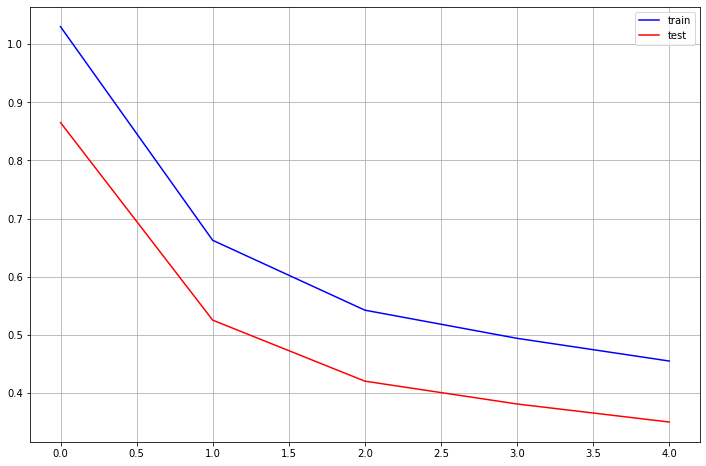

In [731]:
plt.figure(figsize=(12,8))
plt.plot(train_costs_historic, color='blue', label='train')
plt.plot(test_costs_historic, color='red', label='test')
plt.grid(True)
plt.legend()
plt.show()

In [733]:
# En conclusion la red anterior podria generalizar bien porque tiene un buen promedio en la perdida para aprender,
#adicional en minibach ayuda con el epoch a evaluar distintos lotes de datos.